In [2]:
import pandas as pd
# import torchio as tio
import matplotlib.pyplot as plt
import numpy as np

In [7]:
img = np.load('/workspaces/data/MegaGen/testNpy/BraTS-MEN-RT-0200-1_slice_088_img.npy', allow_pickle=True)

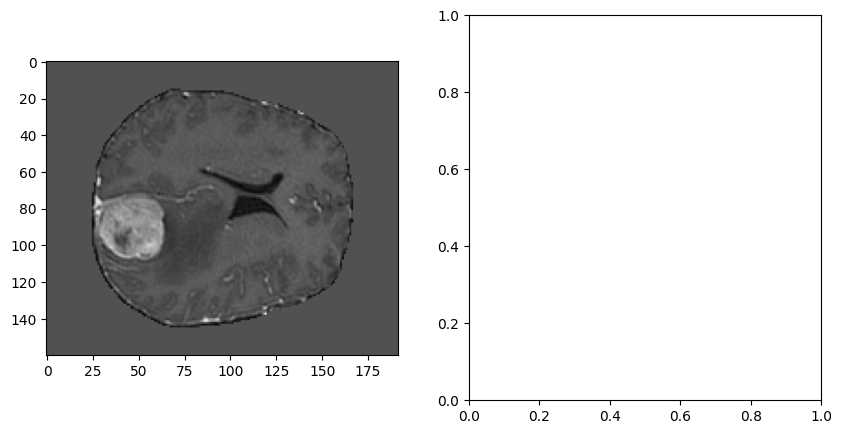

In [8]:
fig, axes = plt.subplots(1,2,figsize=(10, 5))
# img, mask = train_data0[0], train_data0[2]
axes[0].imshow(img, cmap='gray')